In [3]:
import numpy as nu
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import leidenalg

In [4]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor='white')

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


In [7]:
adata = sc.read("/home/jovyan/ifbdata/spatial_cell_id/Kush/data/Clarins_concatenated_adata.h5ad")
adata.write("/home/jovyan/ifbdata/spatial_cell_id/Kush/Scanpy_analysis/cache.h5ad")

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
adata

AnnData object with n_obs × n_vars = 783686 × 20116
    obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication'

In [13]:
adata.var_names_make_unique()

In [15]:
adata.var['ribo'] = adata.var_names.str.startswith(("RpS","RpL"))
adata.var['mt'] = adata.var_names.str.startswith(("Mt"))

sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

normalizing counts per cell


/opt/conda/envs/spatialdata/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:04)


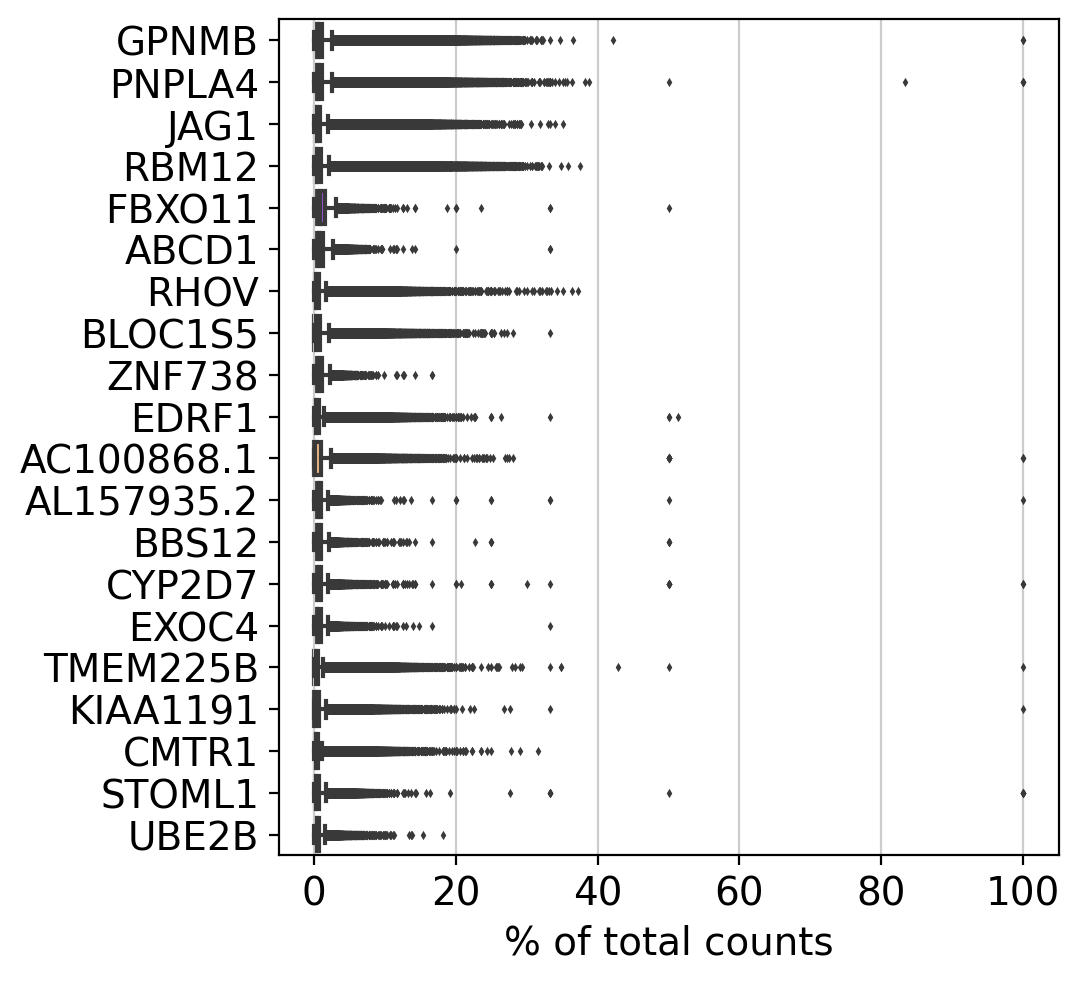

In [21]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

In [29]:
adata.obs['pct_counts_mt']

GAACACTTCATTGCGA    0.0
TCTCACGTCCGCACTT    0.0
CTCCAACTCTCCTACG    0.0
AGATGAAAGACTCGAG    0.0
GCTACCTAGCAATAAC    0.0
                   ... 
ACTCTAATCGGTTAAC    0.0
AGACGTTTCCGTACAA    0.0
CCGGGATCAGCAGTTT    0.0
CGGTTAACAAGTCTAC    0.0
GTAACGTTCTTTACAC    0.0
Name: pct_counts_mt, Length: 783686, dtype: float32